## Импорт библиотек

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve

%matplotlib inline

In [87]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Разделение на тренировачный и тестовый наборы

In [88]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9254,9255,15601116,P'an,686,France,Male,32,6,0.00,2,1,1,179093.26,0
1561,1562,15766374,Leak,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,0
1670,1671,15716994,Green,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,1
6087,6088,15730759,Chukwudi,561,France,Female,27,9,135637.00,1,1,0,153080.40,1
6669,6670,15797900,Chinomso,517,France,Male,56,9,142147.32,1,0,0,39488.04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,5735,15596647,Henderson,768,France,Male,54,8,69712.74,1,1,1,69381.05,0
5191,5192,15681075,Chukwualuka,682,France,Female,58,1,0.00,1,1,1,706.50,0
5390,5391,15573851,Macrossan,735,France,Female,38,1,0.00,3,0,0,92220.12,1
860,861,15807663,McGregor,667,France,Male,43,8,190227.46,1,1,0,97508.04,1


## Беглый взгляд на структуру данных

**Удалим RowNumber, CustomerId и Surname, так как очевидно, что от этих атрибутов целевой признак не должен зависеть**

In [89]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [90]:
df.shape

(10000, 11)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


*Из df.info() видно, что данный датасет не имеет пропусков. Geography и Gender вероятно представляют собой категориальные атрибуты. Посмотрим какие категории существуют*

In [92]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [93]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [94]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


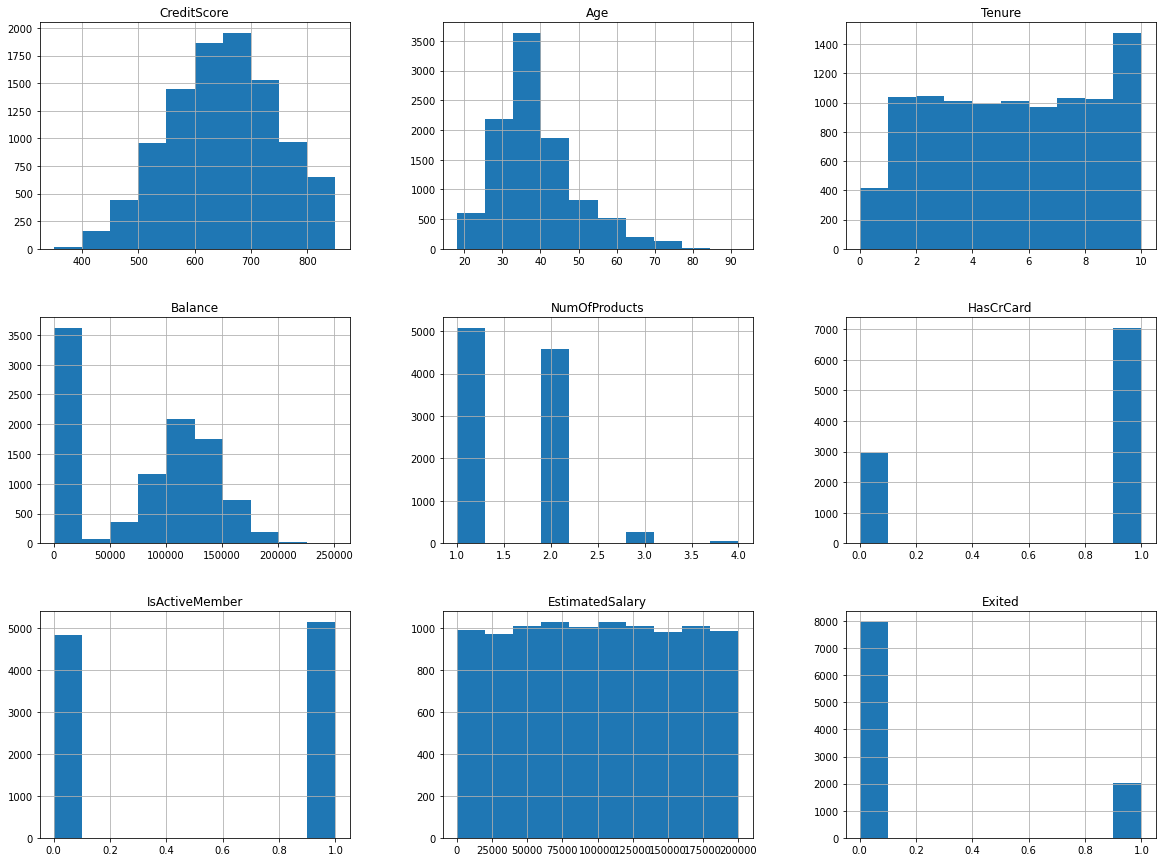

In [95]:
df.hist(figsize=(20, 15))
None

**Рассмотрим атрибуты тренировочного набора**

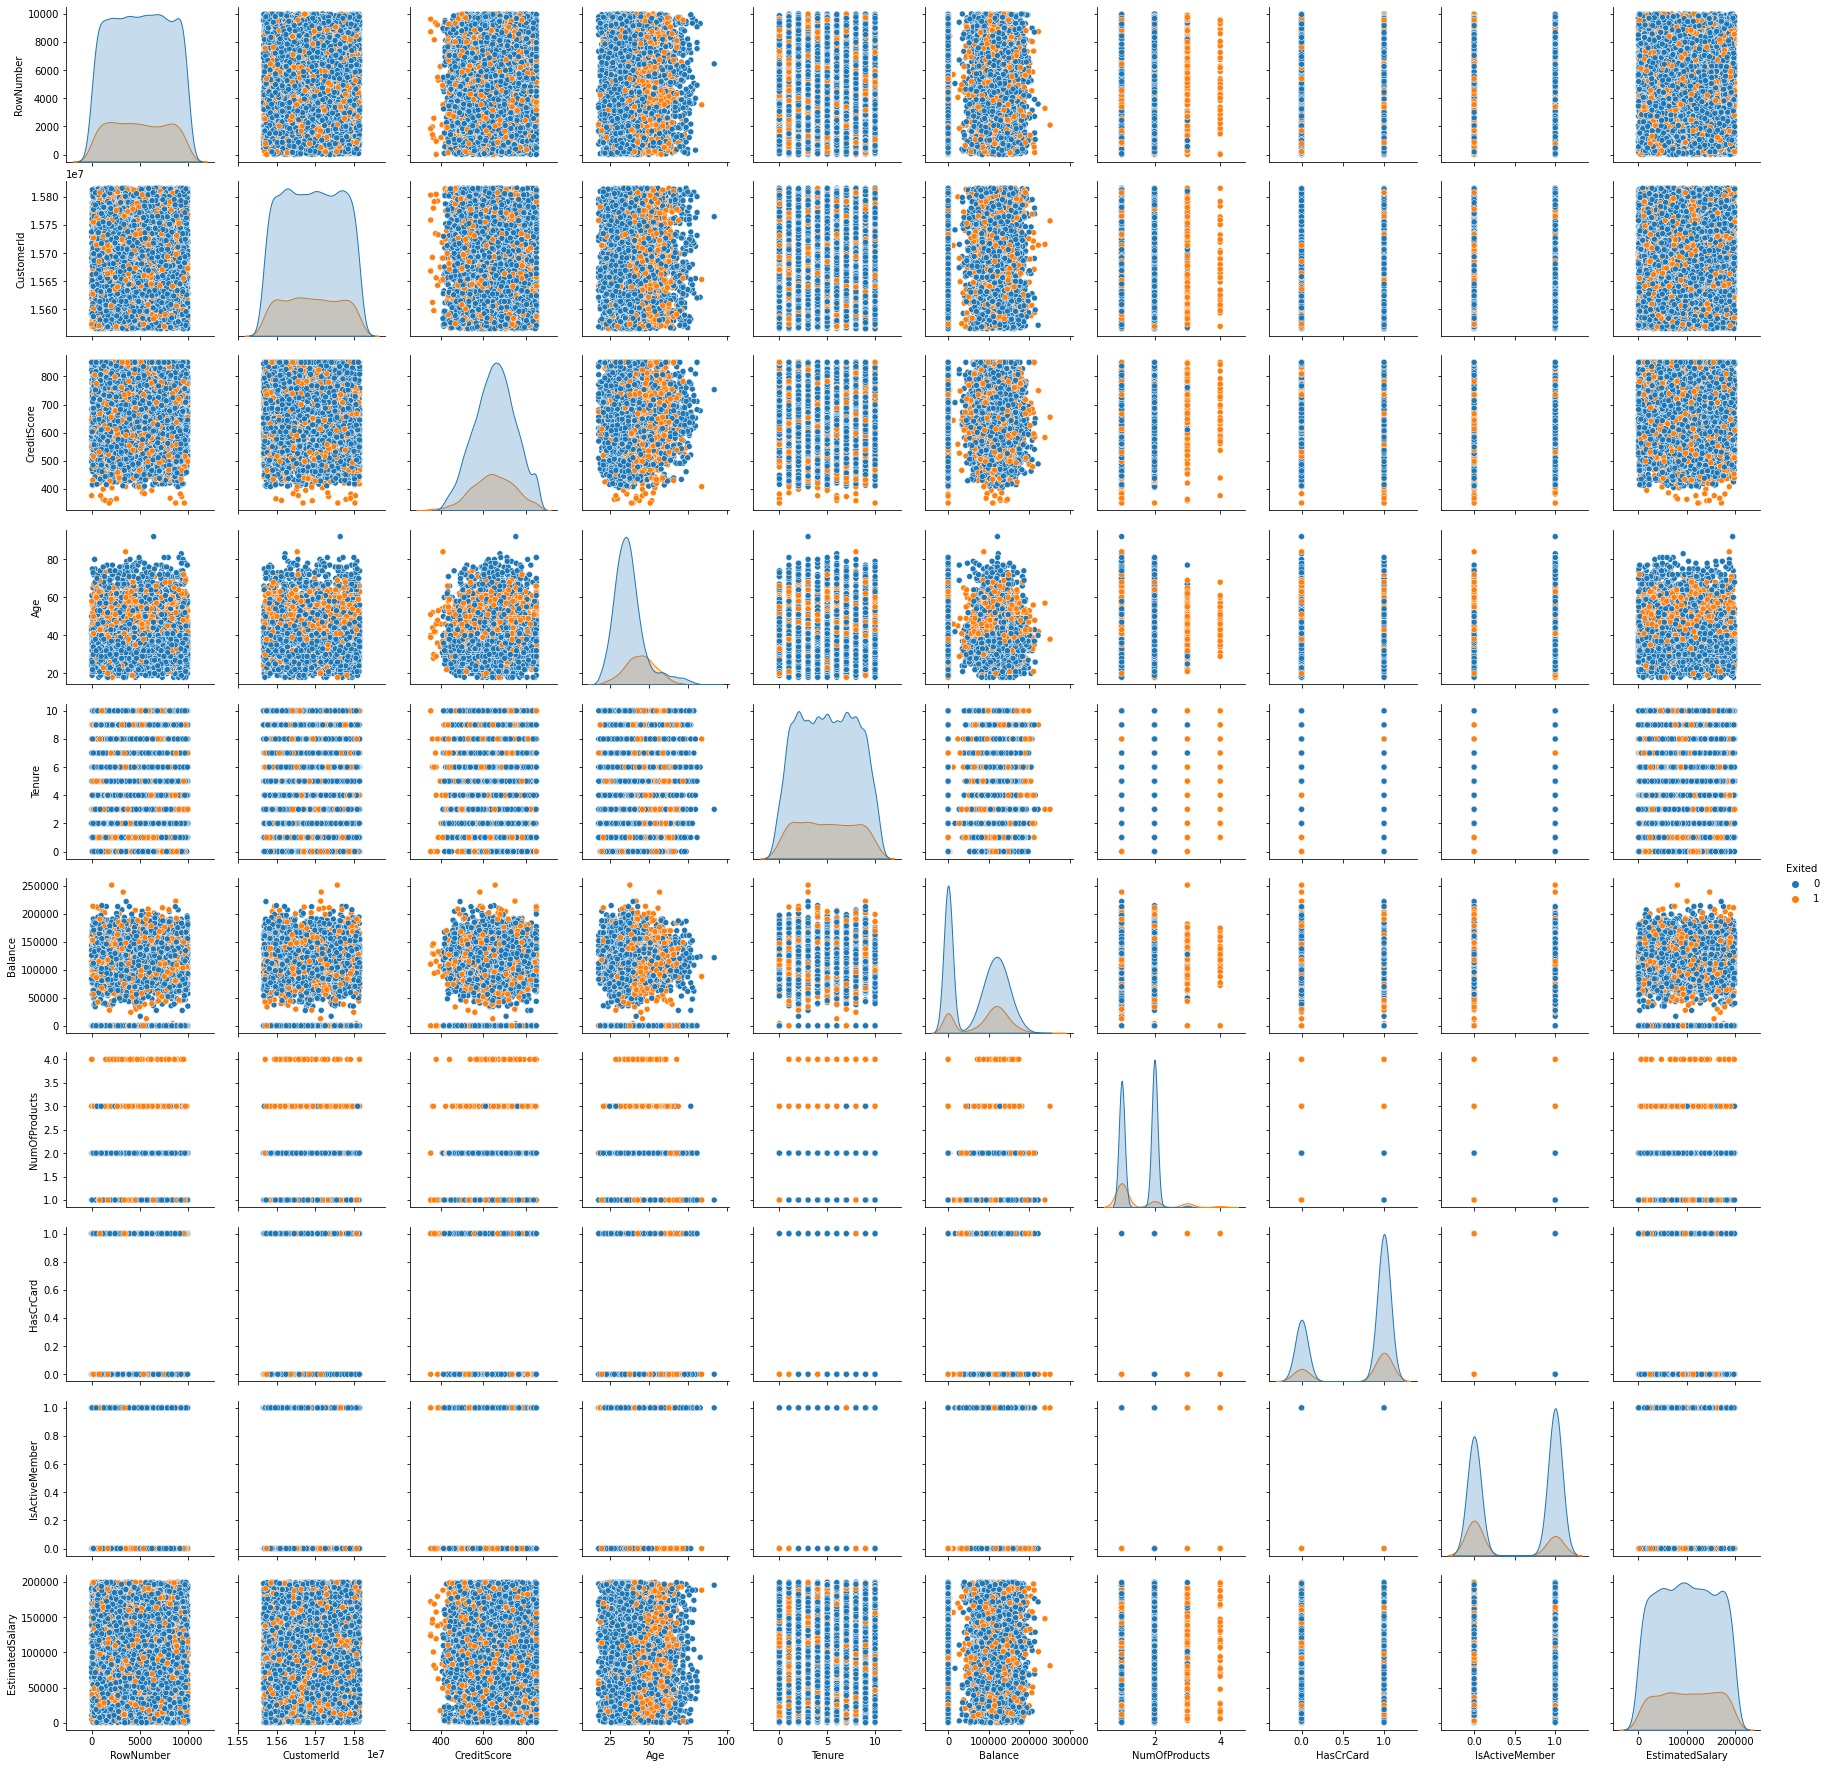

In [96]:
sns.pairplot(df_train, hue='Exited')
None

## Поиск связей

In [97]:
corr_mattr = df_train.corr()
corr_mattr

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.002421,-0.003135,-0.003280,-0.004378,-0.008076,0.002375,-0.000403,0.010064,-0.011891,-0.018759
CustomerId,0.002421,1.000000,0.013950,0.015946,-0.010792,-0.012780,0.017027,-0.010133,-0.002038,0.015607,-0.001739
CreditScore,-0.003135,0.013950,1.000000,-0.007253,-0.007670,0.006758,0.019402,-0.013145,0.028217,-0.002628,-0.029307
Age,-0.003280,0.015946,-0.007253,1.000000,-0.008788,0.027782,-0.033875,-0.020440,0.088123,-0.000997,0.283173
Tenure,-0.004378,-0.010792,-0.007670,-0.008788,1.000000,-0.011748,0.018448,0.020439,-0.023162,0.022071,-0.013352
Balance,-0.008076,-0.012780,0.006758,0.027782,-0.011748,1.000000,-0.297601,-0.015655,-0.022086,0.011984,0.118418
NumOfProducts,0.002375,0.017027,0.019402,-0.033875,0.018448,-0.297601,1.000000,0.003504,0.019543,0.013162,-0.051009
HasCrCard,-0.000403,-0.010133,-0.013145,-0.020440,0.020439,-0.015655,0.003504,1.000000,-0.011913,-0.012799,-0.006471
IsActiveMember,0.010064,-0.002038,0.028217,0.088123,-0.023162,-0.022086,0.019543,-0.011913,1.000000,-0.009852,-0.156560
EstimatedSalary,-0.011891,0.015607,-0.002628,-0.000997,0.022071,0.011984,0.013162,-0.012799,-0.009852,1.000000,0.010889


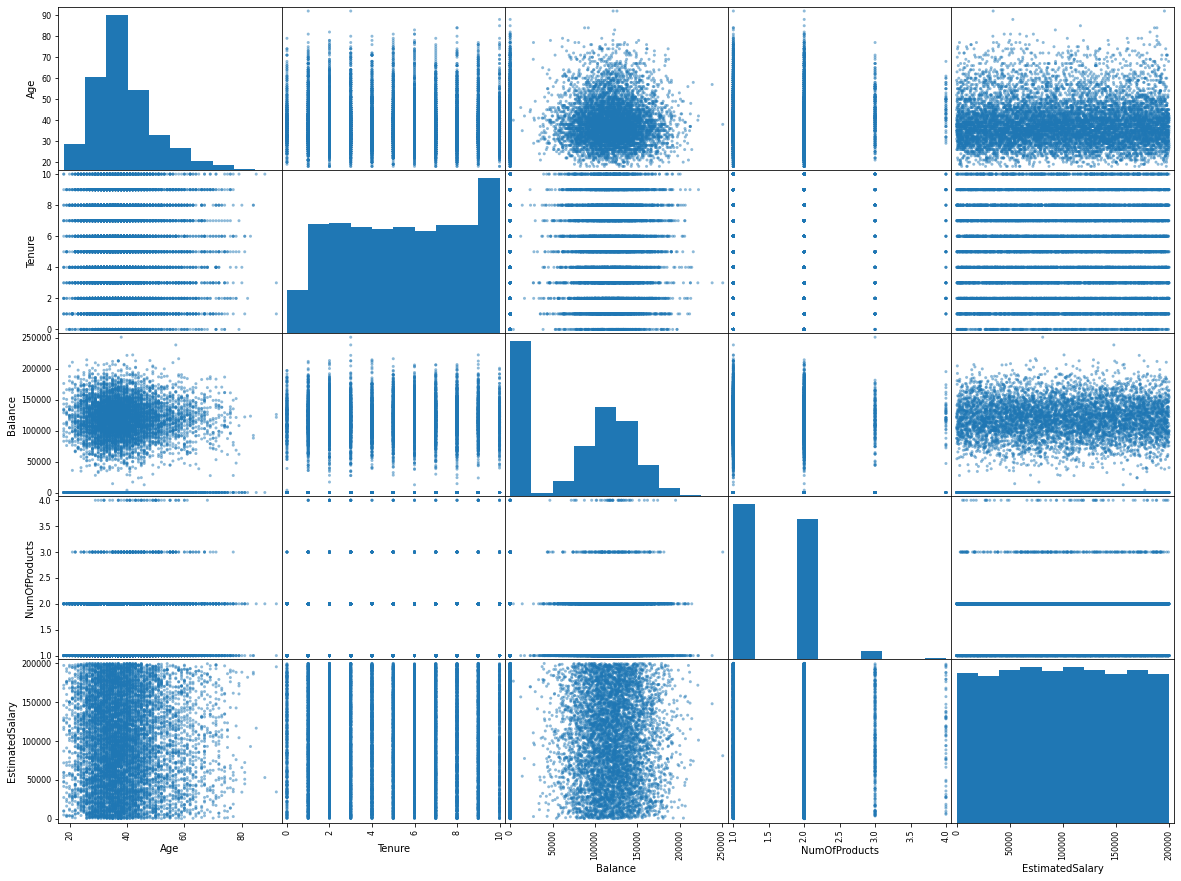

In [98]:
pd.plotting.scatter_matrix(df[['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']], figsize=(20, 15))
None

## Подготовка данных

### Обработка текстовых и категориальных атрибутов

In [99]:
class DataSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attributes].values

In [100]:
num_attr = ['CreditScore', 'Balance', 'EstimatedSalary']
cat_attr = ['Geography', 'Gender']

num_pipeline = Pipeline([
    ('num_selector', DataSelector(num_attr)),
    ('num_standard_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_selector', DataSelector(cat_attr)),
    ('cat_encoder', OneHotEncoder())
])

others_pipeline = Pipeline([
    ('others_attr', DataSelector(df.drop(num_attr+cat_attr, axis=1).columns))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
    ('others_pipeline', others_pipeline)
])

In [101]:
df_train_transform = full_pipeline.fit_transform(df_train)
df_train_prepared = df_train_transform.toarray()
df_train_prepared

array([[ 0.35649971, -1.21847056,  1.36766974, ...,  1.        ,
         1.        ,  0.        ],
       [-0.20389777,  0.69683765,  1.6612541 , ...,  1.        ,
         1.        ,  0.        ],
       [-0.96147213,  0.61862909, -0.25280688, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.86500853, -1.21847056, -0.1427649 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.15932282,  1.8272593 , -0.05082558, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.47065475,  1.1497197 , -0.81456811, ...,  1.        ,
         1.        ,  0.        ]])

In [102]:
df_train_prepared.shape

(8000, 14)

## Выбор и обучение модели

**Разделение тренировачной части на X и y**

In [103]:
X_train = df_train_prepared[:,:-1]
X_train

array([[ 0.35649971, -1.21847056,  1.36766974, ...,  2.        ,
         1.        ,  1.        ],
       [-0.20389777,  0.69683765,  1.6612541 , ...,  2.        ,
         1.        ,  1.        ],
       [-0.96147213,  0.61862909, -0.25280688, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.86500853, -1.21847056, -0.1427649 , ...,  3.        ,
         0.        ,  0.        ],
       [ 0.15932282,  1.8272593 , -0.05082558, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.47065475,  1.1497197 , -0.81456811, ...,  1.        ,
         1.        ,  1.        ]])

In [104]:
y_train = df_train_prepared[:, -1]
y_train

array([0., 0., 1., ..., 1., 1., 0.])

**Выполним решетчатый поиск для подбора гиперпараметров для логистической регрессии**

In [230]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
logistic_clf = LogisticRegression(max_iter=300)
grid_logistic = GridSearchCV(logistic_clf, param_grid=params, cv=10)
grid_logistic.fit(X_train, y_train)
best_logistic_clf = grid_logistic.best_estimator_
grid_logistic.best_params_

{'C': 1}


**Суммы оценок**

In [232]:
cv_res = grid_logistic.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(mean_score, params)

0.7844999999999999 {'C': 0.001}
0.8055 {'C': 0.01}
0.8087500000000001 {'C': 0.1}
0.8089999999999999 {'C': 1}
0.8086249999999999 {'C': 10}
0.8087500000000001 {'C': 100}


## Предсказание модели на тренировочной выборке

In [238]:
# df_test_transform = full_pipeline.fit_transform(df_test)
# df_test_prepared = df_test_transform.toarray()
# X_test = df_test_prepared[:, :-1]
# y_test = df_test_prepared[:, -1]
y_logistic_clf_pred = best_logistic_clf.predict(X_train)
y_logistic_clf_pred_decision = best_logistic_clf.decision_function(X_train)

## Показатели производительности

In [234]:
print(classification_report(y_train, y_logistic_clf_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89      6356
         1.0       0.61      0.22      0.32      1644

    accuracy                           0.81      8000
   macro avg       0.72      0.59      0.61      8000
weighted avg       0.78      0.81      0.77      8000



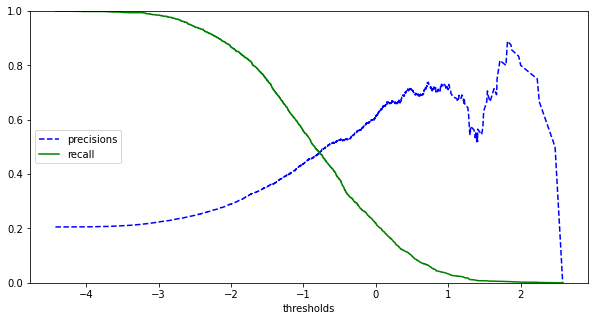

In [235]:
precisions_logistic, recall_logistic, thresholds_logistic = precision_recall_curve(y_train, y_logistic_clf_pred_decision)
plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(thresholds_logistic, precisions_logistic[:-1], 'b--', label='precisions')
plt.plot(thresholds_logistic, recall_logistic[:-1], 'g-', label='recall')
plt.xlabel('thresholds')
plt.legend(loc='center left')
plt.ylim([0, 1])
None

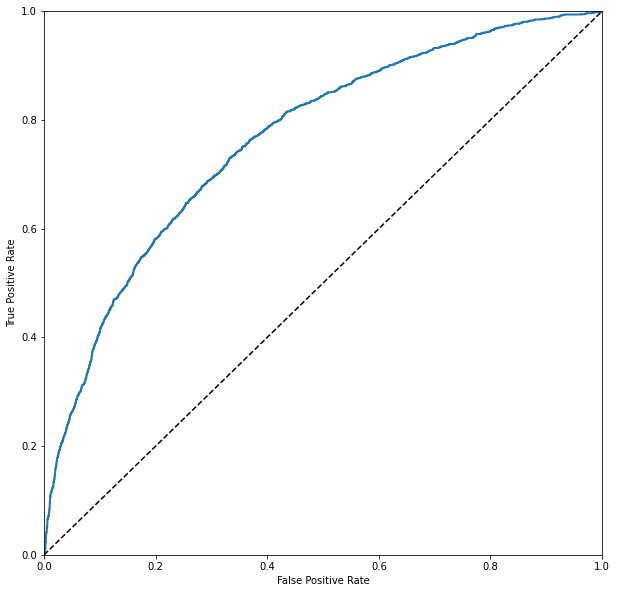

In [236]:
fpr, tpr, thresholds = roc_curve(y_train, y_logistic_clf_pred_decision)
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
None